# Image Feature Extraction from Satellite Imagery

This notebook:
- Loads downloaded satellite images
- Applies preprocessing
- Uses a pretrained CNN to extract visual embeddings
- Saves image features for later multimodal regression


In [1]:
#Core
import os
import numpy as np
import pandas as pd

#Images
from PIL import Image
import matplotlib.pyplot as plt

#Deep Learning
import torch
import torchvision.transforms as T
import torchvision.models as models

from tqdm import tqdm

In [2]:
IMAGE_DIR = "../data/images"
FEATURE_DIR = "../data/img_feature"

os.makedirs(FEATURE_DIR,exist_ok = True)

(-0.5, 59.5, 89.5, -0.5)

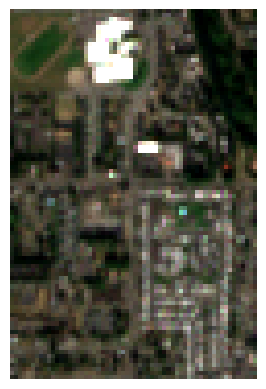

In [3]:
#Sample Check
sample_img = Image.open(os.path.join(IMAGE_DIR, os.listdir(IMAGE_DIR)[0]))
plt.imshow(sample_img)
plt.axis("off")


In [4]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet50(pretrained=True)
model.fc = torch.nn.Identity()   # remove classifier
model = model.to(device)
model.eval()


c:\Users\nimim\OneDrive - iitr.ac.in\Desktop\Projects\Satellite Imagery-Based Property Valuation\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nimim\OneDrive - iitr.ac.in\Desktop\Projects\Satellite Imagery-Based Property Valuation\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
features_dict = {}

for img_name in os.listdir(IMAGE_DIR):
    img_id = os.path.splitext(img_name)[0]   # ← THIS IS CRITICAL
    
    img = Image.open(os.path.join(IMAGE_DIR, img_name)).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        feat = model(img_tensor).squeeze().cpu().numpy()

    features_dict[img_id] = feat


In [ ]:
np.save(
    os.path.join(FEATURE_DIR, "image_features.npy"),
    features_dict
)


In [10]:
df_img = pd.DataFrame.from_dict(features_dict, orient="index")
df_img.index.name = "id"
df_img.reset_index(inplace=True)

df_img.to_parquet(
    os.path.join(FEATURE_DIR, "image_features.parquet")
)


c:\Users\nimim\OneDrive - iitr.ac.in\Desktop\Projects\Satellite Imagery-Based Property Valuation\.venv\lib\site-packages\pandas\io\parquet.py:159: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)
